# Predicting house prices - a regression example

regression consists of predicting a continuous value instead of a discrete label: 

predicting the temperature tomorrow, given meteorological data; 

predicting the time that a software project will take to complete, given its specifications.

#### The Boston Housing Price dataset

You’ll attempt to predict the median price of homes in a given Boston suburb in the
mid-1970s, given data points about the suburb at the time, such as the crime rate, the
local property tax rate, and so on. 

It has relatively few data points: only 506, split between 404 training samples and 102 test samples. 
    
Each feature in the input data (for example, the crime rate) has a different scale. For instance, some values are proportions, which take values between 0 and 1; others take values between 1 and 12, others between 0 and 100, and so on.

### Loading the Boston housing dataset

In [1]:
# Force Keras to use CPU
# Windows
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


## Linux
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [3]:
train_data.shape, test_data.shape

((404, 13), (102, 13))

The targets are the median values of owner-occupied homes, in thousands of
dollars:

In [4]:
train_targets

array([ 15.2,  42.3,  50. ,  21.1,  17.7,  18.5,  11.3,  15.6,  15.6,
        14.4,  12.1,  17.9,  23.1,  19.9,  15.7,   8.8,  50. ,  22.5,
        24.1,  27.5,  10.9,  30.8,  32.9,  24. ,  18.5,  13.3,  22.9,
        34.7,  16.6,  17.5,  22.3,  16.1,  14.9,  23.1,  34.9,  25. ,
        13.9,  13.1,  20.4,  20. ,  15.2,  24.7,  22.2,  16.7,  12.7,
        15.6,  18.4,  21. ,  30.1,  15.1,  18.7,   9.6,  31.5,  24.8,
        19.1,  22. ,  14.5,  11. ,  32. ,  29.4,  20.3,  24.4,  14.6,
        19.5,  14.1,  14.3,  15.6,  10.5,   6.3,  19.3,  19.3,  13.4,
        36.4,  17.8,  13.5,  16.5,   8.3,  14.3,  16. ,  13.4,  28.6,
        43.5,  20.2,  22. ,  23. ,  20.7,  12.5,  48.5,  14.6,  13.4,
        23.7,  50. ,  21.7,  39.8,  38.7,  22.2,  34.9,  22.5,  31.1,
        28.7,  46. ,  41.7,  21. ,  26.6,  15. ,  24.4,  13.3,  21.2,
        11.7,  21.7,  19.4,  50. ,  22.8,  19.7,  24.7,  36.2,  14.2,
        18.9,  18.3,  20.6,  24.6,  18.2,   8.7,  44. ,  10.4,  13.2,
        21.2,  37. ,

### Preparing the data

##### Normalizing the data

It would be problematic to feed into a neural network values that all take wildly different ranges. 

The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult.

A widespread best practice to deal with such data is to do feature-wise normalization: 
for each feature in the input data (a column in the input data matrix), you subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. 

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

**Note that the quantities used for normalizing the test data are computed using the
training data. You should never use in your workflow any quantity computed on the
test data, even for something as simple as data normalization.**

#### Building your network

Because so few samples are available, you’ll use a very small network with two hidden layers, each with 64 units. 

In general, the less training data you have, the worse overfitting will be, and using a small network is one way to mitigate overfitting

### Model definition

In [6]:
from keras import models
from keras import layers


def build_model():  # Because you’ll need to instantiate the same model multiple times, you use a function to construct it.
    model = models.Sequential()

    model.add(layers.Dense(64, activation="relu", input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))

    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

    return model

The network ends with a single unit and *no activation* (it will be a linear layer). 
This is a typical setup for scalar regression (a regression where you’re trying to predict a single continuous value). 

Applying an activation function would constrain the range the output can take; for instance, if you applied a sigmoid activation function to the last layer, the network could only learn to predict values between 0 and 1. Here, because the last layer is purely linear, the network is free to learn to predict values in any range.

You compile the network with the *mse* loss function—mean squared error.

You’re also monitoring a new metric during training: mean absolute error (MAE). 

#### Validating your approach using K-fold validation

To evaluate your network while you keep adjusting its parameters (such as the number of epochs used for training), you could split the data into a training set and a validation set, as you did in the previous examples. 

But because you have so few data points, the validation set would end up being very small (for instance, about 100 examples).

As a consequence, the validation scores might change a lot depending on which data points you chose to use for validation and which you chose for training: 
the validation scores might have a high variance with regard to the validation split. This would prevent you from reliably evaluating your model.

The best practice in such situations is to use K-fold cross-validation.
It consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on K – 1 partitions while evaluating on
the remaining partition. The validation score for the model used is then the average of the K validation scores obtained. In terms of code, this is straightforward.

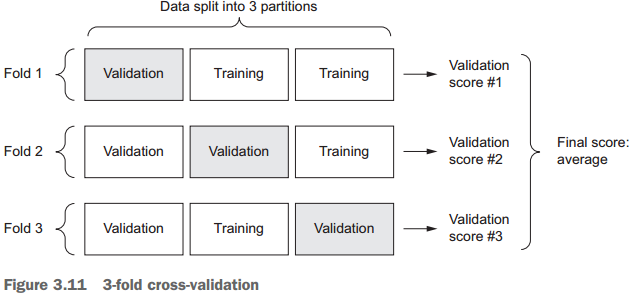

In [7]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print("processing fold #", i)
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples], train_data[(i + 1) * num_val_samples :]],
        axis=0,
    )

    partial_train_targets = np.concatenate(
        [
            train_targets[: i * num_val_samples],
            train_targets[(i + 1) * num_val_samples :],
        ],
        axis=0,
    )

    model = build_model()

    model.fit(
        partial_train_data,
        partial_train_targets,
        epochs=num_epochs,
        batch_size=1,
        verbose=0,
    )

    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)

    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


Running this with num_epochs = 100 yields the following results:

In [8]:
all_scores

[2.053658892612646, 2.1217013089963705, 2.9549630620692038, 2.4545334553954623]

In [9]:
np.mean(all_scores)

2.3962141797684211

Let’s try training the network a bit longer: 500 epochs. To keep a record of how well the model does at each epoch, you’ll modify the training loop to save the perepoch validation score log:

In [10]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print("processing fold #", i)
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples], train_data[(i + 1) * num_val_samples :]],
        axis=0,
    )

    partial_train_targets = np.concatenate(
        [
            train_targets[: i * num_val_samples],
            train_targets[(i + 1) * num_val_samples :],
        ],
        axis=0,
    )

    model = build_model()

    history = model.fit(
        partial_train_data,
        partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs,
        batch_size=1,
        verbose=0,
    )

    mae_history = history.history["val_mean_absolute_error"]

    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


You can then compute the average of the per-epoch MAE scores for all folds.

In [11]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

#### Plotting validation scores

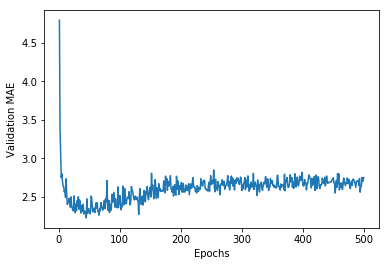

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

It may be a little difficult to see the plot, due to scaling issues and relatively high variance. Let’s do the following:
* Omit the first 10 data points, which are on a different scale than the rest of the curve.
* Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

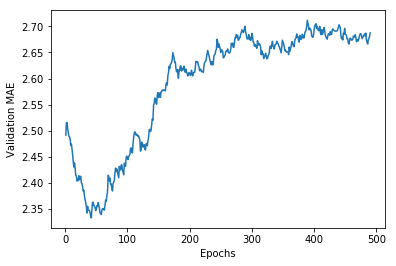

In [13]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

According to this plot, validation MAE stops improving significantly after 80 epochs. Past that point, you start overfitting.

Once you’re finished tuning other parameters of the model (in addition to the number of epochs, you could also adjust the size of the hidden layers), you can train a final production model on all of the training data, with the best parameters, and then look at its performance on the test data.

#### Training the final model

In [14]:
model = build_model()

model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 784us/step


In [15]:
test_mae_score

2.676392573936313

#### Wrapping up

Here’s what you should take away from this example:

* Regression is done using different loss functions than what we used for classification. Mean squared error (MSE) is a loss function commonly used for regression.

* Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally, the concept of accuracy doesn’t apply for regression. A common regression metric is mean absolute error (MAE).

* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.

* When there is little data available, using K-fold validation is a great way to reliably evaluate a model.

* When little training data is available, it’s preferable to use a small network with few hidden layers (typically only one or two), in order to avoid severe overfitting.

### Chapter summary

* You’re now able to handle the most common kinds of machine-learning tasks on vector data: binary classification, multiclass classification, and scalar regression. The “Wrapping up” sections earlier in the chapter summarize the important points you’ve learned regarding these types of tasks.

* You’ll usually need to preprocess raw data before feeding it into a neural network.

* When your data has features with different ranges, scale each feature independently as part of preprocessing.

* As training progresses, neural networks eventually begin to overfit and obtain worse results on never-before-seen data.

* If you don’t have much training data, use a small network with only one or two hidden layers, to avoid severe overfitting.

* If your data is divided into many categories, you may cause information bottlenecks if you make the intermediate layers too small.

* Regression uses different loss functions and different evaluation metrics than classification.

* When you’re working with little data, K-fold validation can help reliably evaluate your model.